<a href="https://colab.research.google.com/github/itberrios/CV_projects/blob/main/optical_flow/fan_track_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fan track Simple**

Simple way to track fan baldes and estimate their angular velocity. Each fan blade in the video is about 22" and is about 26" from tip to center of rotation.The fan has 5 blades that are equidistant with eachother, so we will assume each blade is spaced 72 degrees apart (360/5 = 72).

In [1]:
import os
import sys
import numpy as np
import cv2
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
!wget https://raw.githubusercontent.com/itberrios/CV_projects/main/fan.MOV

--2023-10-08 22:06:19--  https://raw.githubusercontent.com/itberrios/CV_projects/main/fan.MOV
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2065412 (2.0M) [video/quicktime]
Saving to: ‘fan.MOV’

fan.MOV             100%[===================>]   1.97M  --.-KB/s    in 0.08s   

2023-10-08 22:06:19 (24.2 MB/s) - ‘fan.MOV’ saved [2065412/2065412]



In [3]:
video = cv2.VideoCapture("fan.MOV")

if (video.isOpened() == False):
    print("Error opening video file")

# get frame rate
fps = video.get(cv2.CAP_PROP_FPS)

frames = []
while(video.isOpened()):

    # read each video frame
    ret, frame = video.read()

    if ret == True:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

    # Break if nothing is returned
    else:
        break

# clean up
video.release()
cv2.destroyAllWindows()
del video

The main idea is to determine if a fan blade passes a certain boundary. We can use the frequency of this fan blade to determine the angular velocity of the fan. We will use dense Optical flow to determine when a fan blade passes the boundary

#### **Assumptions**
- Fan dimensions are known
- Camera is stationary

Another way would be to use sparse optical flow and determine the overall rigid body transformations between frames.

We could also exploit the stationarity of the fan and use the assumption that most background objects do not move and compute the rigid body transformation between frames, we could use that along with the known fan dimensions to directly estimate the fan's angular vecloity.

In [4]:
idx = 6

frame1 = frames[idx]
frame2 = frames[idx + 1]

In [5]:
boundary_line = np.array([275, 0, 275, 50])
x1,y1,x2,y2 = boundary_line

In [6]:
bframe = cv2.line(frame1.copy(), (x1,y1), (x2,y2), (0,255,0), 3)

# bframe = cv2.rectangle(frame1.copy(), (250, 0), (285, 100), (0,255,0), 3)

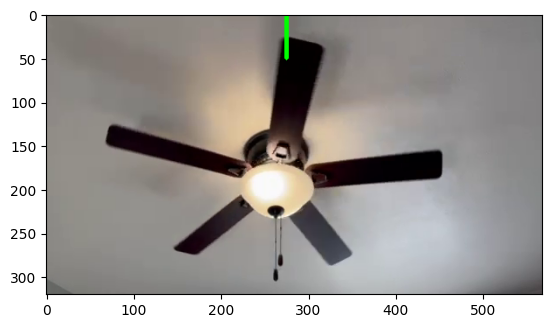

In [7]:
plt.imshow(bframe)

### Compute Optical Flow

Let's write a function to compute dense Optical Flow. We will use Farenbeck's method as implemented in opencv. We opt not to use any Deep Optical flow methods because they are highly sensitive to shadows and have even been observed to hallucinate flows that are not even present. We will still be able to make use of the more noisy flow that is computed from classical methods.

In [57]:
def compute_flow(frame1, frame2):
    # convert to grayscale
    gray1 = cv2.cvtColor(frame1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(frame2, cv2.COLOR_RGB2GRAY)

    # blurr image
    gray1 = cv2.GaussianBlur(gray1, dst=None, ksize=(3,3), sigmaX=5)
    gray2 = cv2.GaussianBlur(gray2, dst=None, ksize=(3,3), sigmaX=5)

    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None,
                                        pyr_scale=0.5,
                                        levels=3,
                                        winsize=5,
                                        iterations=3,
                                        poly_n=10,
                                        poly_sigma=1.2,
                                        flags=0)

    return flow


def viz_flow(flow):
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3)).astype(np.uint8)
    hsv[..., 1] = 255
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang*180/np.pi/2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

    return rgb

## **Pipeline**

Now let's make the pipeline! Determine if moving fan blade has crossed the line (we can clean this up later). All we need to do is consider all vertical pixels less than 50 at horizontal position 275 and add a +/-5 padding to help out. If the detected fan motion has encroached on this, then we can label this a "blade detection"!


Here is the outline:
1. Get Frame pair
2. Compute Dense Optical Flow
3. Get dense horizontal flow

In [96]:
y_slice = slice(0, y2)
x_slice = slice(270, 281)

delta_theta = np.radians(72)

morph_kernel = np.ones((1, 11))

In [137]:
results = []
omegas = []
rpms = []

detected = 0
prev_detection_frame = 0

for i in range(1, len(frames)):

    # get frame pair
    prev_frame = frames[i - 1]
    curr_frame = frames[i]

    # compute Optical Flow
    flow = compute_flow(prev_frame, curr_frame)

    # get leftward and rightward motion
    left_motion = (flow[:, :, 0] < -1).astype(np.uint8)*255
    right_motion = (flow[:, :, 0] > 1).astype(np.uint8)*255

    # horizontal motion
    motion = left_motion | right_motion

    # clean up patch of interest
    opening = cv2.morphologyEx(motion[y_slice, x_slice], cv2.MORPH_OPEN, morph_kernel)

    # print(opening.shape, np.sum(opening))

    # determine if the fan has crossed the boundary
    if np.sum(opening) > 255: # set threshold
        if detected == 0:

            # compute velocity
            omega = delta_theta/((i - prev_detection_frame)/fps)
            omegas.append(omega)
            rpms.append(omega*30/np.pi)

            prev_detection_frame = i

        results.append(1)
        detected = 1

    else:
        results.append(0)
        detected = 0

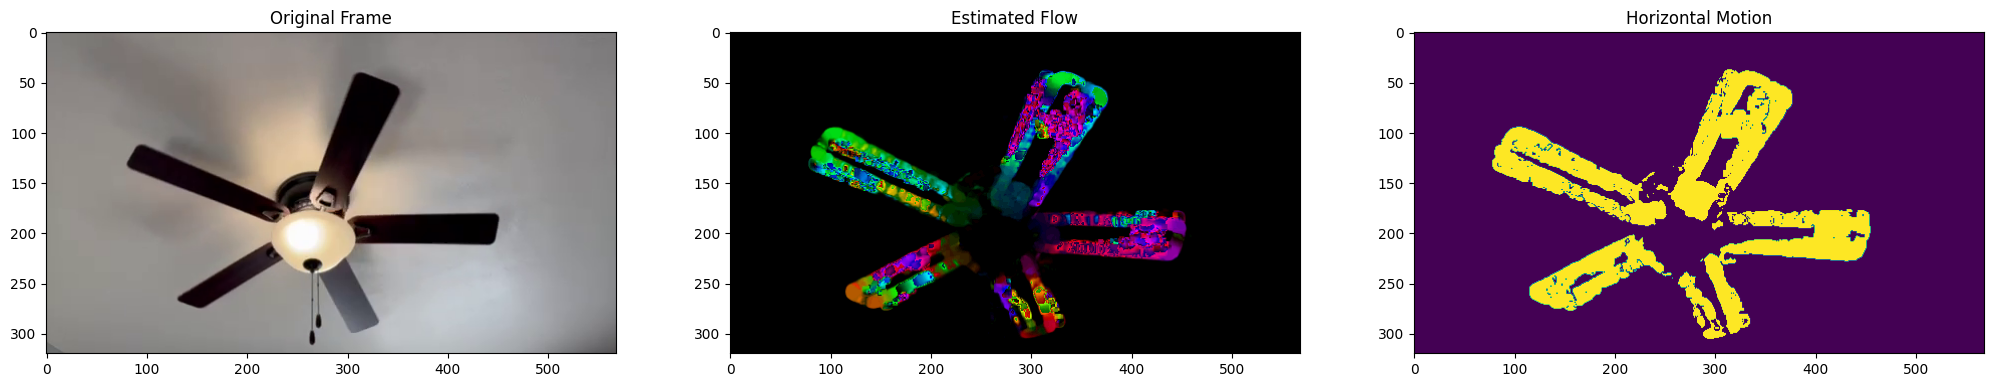

In [93]:
_, ax = plt.subplots(1, 3, figsize=(25, 10))
ax[0].imshow(curr_frame)
ax[0].set_title("Original Frame")

ax[1].imshow(viz_flow(flow)*10)
ax[1].set_title("Estimated Flow")

ax[2].imshow(motion)
ax[2].set_title("Horizontal Motion");

## Now let's plot the results!

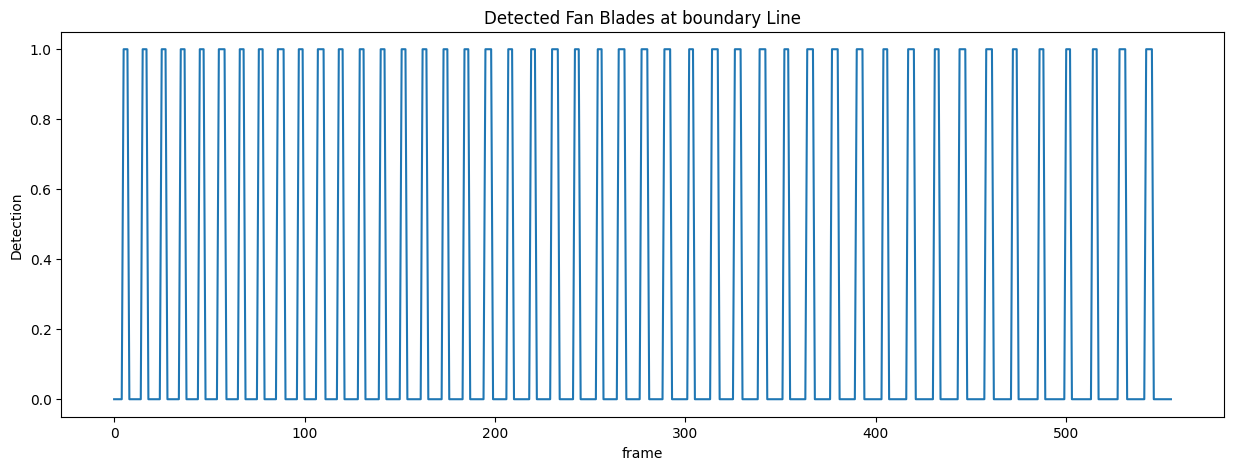

In [81]:
plt.figure(figsize=(15, 5))
plt.plot(results)
plt.title("Detected Fan Blades at boundary Line")
plt.xlabel("frame")
plt.ylabel("Detection");

Now we only need to know when the detection goes high and compute it against when the detection

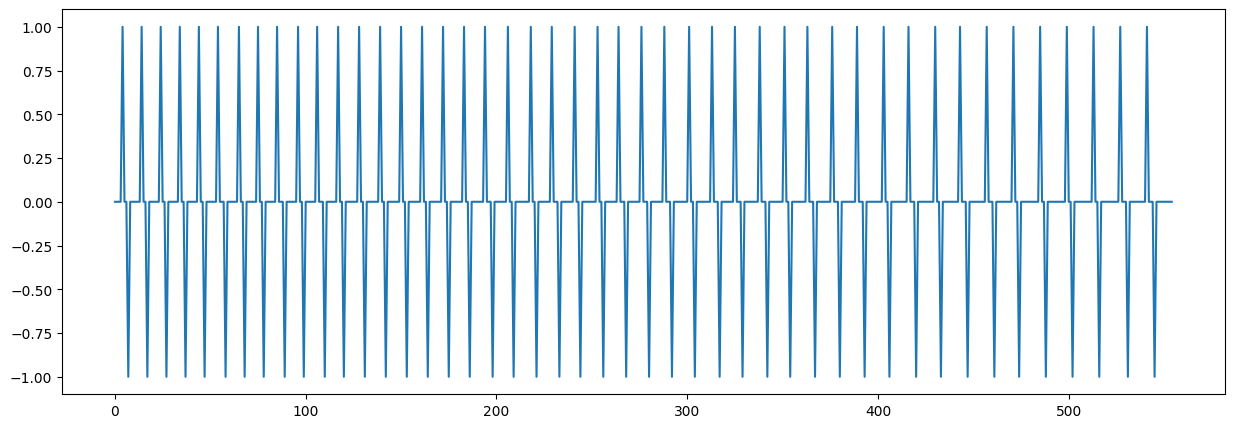

In [84]:
plt.figure(figsize=(15, 5))
plt.plot(np.diff(results));

In [112]:
detections = np.where(np.diff(results, prepend=0) == 1)[0]
detections

array([  5,  15,  25,  35,  45,  55,  66,  76,  86,  97, 107, 118, 129,
       140, 151, 162, 173, 184, 195, 207, 219, 230, 242, 254, 265, 277,
       289, 302, 314, 326, 339, 352, 364, 377, 390, 404, 417, 430, 444,
       458, 472, 486, 499, 513, 528, 542])

In [113]:
fps

30.0

In [129]:
omegas = [] # radians per second
rpms = []   # revolutons per minute

prev_d = detections[0]
for d in detections[1:]:
    omega = delta_theta/((d-prev_d)/fps)
    omegas.append(omega)
    rpms.append(omega*30/np.pi)
    prev_d = d

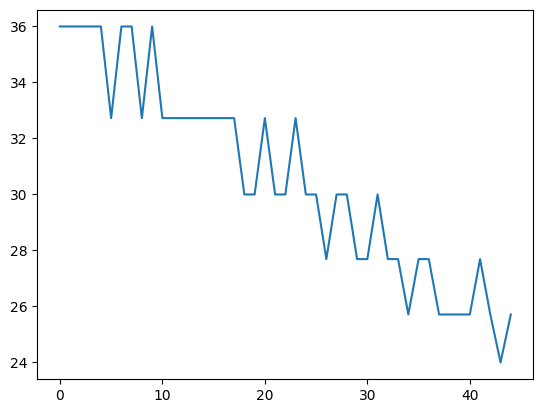

In [131]:
plt.plot(rpms)

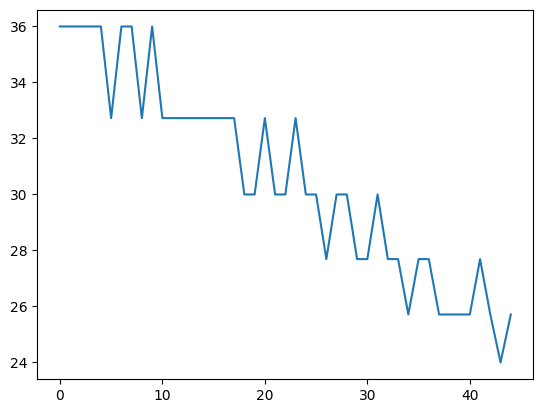

In [140]:
plt.plot(rpms[1:])

In [133]:
omegas[0]

3.7699111843077517

In [135]:
omegas[0]/(2*np.pi)

0.6

In [128]:
216 * 0.1667

36.0072

In [127]:
216/180

1.2

## **Compute Kalman Filtered Angular Velocity**

Now we will re-estimate the angular velocity and use a Kalman Filter to increase the overall quality of the estimates.